In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
from google.colab import files
from IPython.display import Image
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from PIL import Image
import os
import pandas as pd
import shutil
import cv2
from tensorflow.keras.datasets import fashion_mnist
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.utils import shuffle

In [1]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=295a5e2fe8efb9f13c5803fb03d8e89d61d2ef43950e9d9aea9c9471254039d4
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=e113d9b27ba5b5290029c6c96477ab3683befbfa973c3c5b51e19538b37379ee
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
from google.colab import drive, auth
auth.authenticate_user()
import requests
gcloud_token = !gcloud auth print-access-token
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Каталог с данными для обучения
train_dir = '/content/drive/My Drive/Colab Notebooks/Market_Exchange/train/'
# Каталог с данными для проверки
val_dir = '/content/drive/My Drive/Colab Notebooks/Market_Exchange/val/'
# Каталог с данными для тестирования
test_dir = '/content/drive/My Drive/Colab Notebooks/Market_Exchange/test/'
# Размеры изображения
img_width, img_height = 224, 224
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 1)
# Размер мини-выборки
batch_size = 64
# Количество изображений для обучения
nb_train_samples = 1520
# Количество изображений для проверки
nb_validation_samples = 400
# Количество изображений для тестирования
nb_test_samples = 388
epochs = 30


(<matplotlib.image.AxesImage at 0x7fcc46f7d6d8>, (500, 500))

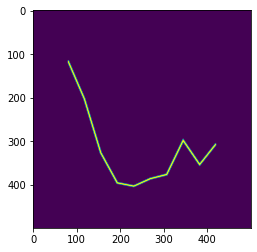

In [0]:

im = cv2.imread('/content/drive/My Drive/Colab Notebooks/Market_Exchange/test/up/image_2474.png',cv2.IMREAD_UNCHANGED)[:,:,-1]
imshow(im), np.shape(im)

In [0]:
images = list()
folder = os.walk('/content/drive/My Drive/Colab Notebooks/Market_Exchange/images')
for address, dirs, files in folder:
  for file in files:
    im = cv2.imread(address+'/'+file,cv2.IMREAD_UNCHANGED)[:,:,-1]
    im = cv2.resize(im, (224, 224)).astype(np.float32)
    images.append(im)

In [0]:
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Market_Exchange/label_10.txt')
labels[labels != 'down'] = 1
labels[labels == 'down'] = 0
labels

,up
0,0
1,1
2,1
3,1
4,1
...,...
8661,1
8662,0
8663,1
8664,0


In [0]:
labels = labels[:2302]
images, labels = shuffle(images, labels)
labels_train = labels[0:2000]
labels_test = labels[2001:2302]

In [0]:
for i in range(len(images)):
  images[i] = images[i] / 255

In [0]:
train = images[0:2000]
test = images[2001:2302]
np.shape(train), np.shape(test)

((2000, 224, 224), (301, 224, 224))

In [0]:
train = np.asarray(train).astype(np.float32)
labels_train = np.asarray(labels_train).astype(np.float32)
labels_train = labels_train.reshape(2000)
test = np.asarray(test).astype(np.float32)
labels_test = np.asarray(labels_test).astype(np.float32)
labels_test = labels_test.reshape(301)
x_train = tf.convert_to_tensor(train)
labels_train = labels_train.reshape(2000)
train = train.reshape(2000, 224, 224, 1)
test = test.reshape(301, 224, 224, 1)

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu', input_shape = (224,224,1)))
#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu'))
#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(450, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 16)      416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 32)      12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)           

In [0]:
adam = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [0]:
history = model.fit(train, labels_train, 
                    batch_size=64, 
                    epochs=5,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/5
25/25 [==============================] - 58s 2s/step - loss: 0.3921 - accuracy: 0.8225 - val_loss: 1.4313 - val_accuracy: 0.4975
Epoch 2/5
25/25 [==============================] - 59s 2s/step - loss: 0.2519 - accuracy: 0.8850 - val_loss: 1.5525 - val_accuracy: 0.4325
Epoch 3/5
25/25 [==============================] - 58s 2s/step - loss: 0.1947 - accuracy: 0.9225 - val_loss: 1.7281 - val_accuracy: 0.4600
Epoch 4/5
25/25 [==============================] - 58s 2s/step - loss: 0.1559 - accuracy: 0.9519 - val_loss: 1.7972 - val_accuracy: 0.4750
Epoch 5/5
25/25 [==============================] - 58s 2s/step - loss: 0.1219 - accuracy: 0.9594 - val_loss: 1.8898 - val_accuracy: 0.4650


In [0]:
v def build_model(hp):
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu', input_shape = (224,224,1)))
#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                 activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu'))
#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(450, activation='selu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
              optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
              metrics=['accuracy'])
  return model

In [0]:
model.evaluate(test, labels_test, verbose = 1)

10/10 [==============================] - 7s 737ms/step - loss: 0.8720 - accuracy: 0.5083


[0.8720468282699585, 0.5083056688308716]

In [0]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать - 
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=15,               # максимальное количество запусков обучения 
    directory='test_directory_1'   # каталог, куда сохраняются обученные сети  
    )

In [0]:
tuner.search_space_summary()

In [0]:
tuner.search(train,                  # Данные для обучения
             labels_train,                  # Правильные ответы
             batch_size=64,           # Размер мини-выборки
             epochs=10,                # Количество эпох обучения 
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки
             )

Epoch 1/10
25/25 [==============================] - 135s 5s/step - loss: 4.6974 - accuracy: 0.5275 - val_loss: 0.7336 - val_accuracy: 0.5300
Epoch 2/10
25/25 [==============================] - 136s 5s/step - loss: 1.2400 - accuracy: 0.4913 - val_loss: 0.8818 - val_accuracy: 0.4725
Epoch 3/10
25/25 [==============================] - 133s 5s/step - loss: 1.2097 - accuracy: 0.4681 - val_loss: 0.7618 - val_accuracy: 0.4725
Epoch 4/10
25/25 [==============================] - 134s 5s/step - loss: 1.1843 - accuracy: 0.4963 - val_loss: 0.7315 - val_accuracy: 0.5275
Epoch 5/10
25/25 [==============================] - 135s 5s/step - loss: 1.0690 - accuracy: 0.5300 - val_loss: 1.5784 - val_accuracy: 0.5325
Epoch 6/10
25/25 [==============================] - 137s 5s/step - loss: 1.0184 - accuracy: 0.5506 - val_loss: 0.8378 - val_accuracy: 0.5025
Epoch 7/10
25/25 [==============================] - 132s 5s/step - loss: 0.9036 - accuracy: 0.6056 - val_loss: 1.4000 - val_accuracy: 0.4800
Epoch 8/10
25

Epoch 1/10
25/25 [==============================] - 133s 5s/step - loss: 1.2959 - accuracy: 0.5113 - val_loss: 1.0137 - val_accuracy: 0.4625
Epoch 2/10
25/25 [==============================] - 132s 5s/step - loss: 0.6135 - accuracy: 0.6806 - val_loss: 1.1028 - val_accuracy: 0.4650
Epoch 3/10
25/25 [==============================] - 133s 5s/step - loss: 0.4119 - accuracy: 0.8138 - val_loss: 1.0953 - val_accuracy: 0.4950
Epoch 4/10
25/25 [==============================] - 130s 5s/step - loss: 0.2681 - accuracy: 0.9006 - val_loss: 1.2141 - val_accuracy: 0.4950
Epoch 5/10
25/25 [==============================] - 132s 5s/step - loss: 0.2147 - accuracy: 0.9256 - val_loss: 1.4220 - val_accuracy: 0.4675
Epoch 6/10
25/25 [==============================] - 129s 5s/step - loss: 0.1620 - accuracy: 0.9419 - val_loss: 1.4588 - val_accuracy: 0.4850
Epoch 7/10
25/25 [==============================] - 131s 5s/step - loss: 0.1448 - accuracy: 0.9538 - val_loss: 1.6651 - val_accuracy: 0.4750
Epoch 8/10
25

Epoch 1/10
25/25 [==============================] - 128s 5s/step - loss: 0.6990 - accuracy: 0.4988 - val_loss: 0.7034 - val_accuracy: 0.4900
Epoch 2/10
25/25 [==============================] - 128s 5s/step - loss: 0.6766 - accuracy: 0.5719 - val_loss: 0.7026 - val_accuracy: 0.5200
Epoch 3/10
25/25 [==============================] - 127s 5s/step - loss: 0.6663 - accuracy: 0.5981 - val_loss: 0.7109 - val_accuracy: 0.4950
Epoch 4/10
25/25 [==============================] - 129s 5s/step - loss: 0.6561 - accuracy: 0.6169 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 129s 5s/step - loss: 0.6392 - accuracy: 0.6463 - val_loss: 0.7166 - val_accuracy: 0.4900
Epoch 6/10
25/25 [==============================] - 128s 5s/step - loss: 0.6256 - accuracy: 0.6619 - val_loss: 0.7259 - val_accuracy: 0.5025
Epoch 7/10
25/25 [==============================] - 128s 5s/step - loss: 0.6127 - accuracy: 0.6794 - val_loss: 0.7265 - val_accuracy: 0.4950
Epoch 8/10
25

INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()

In [0]:
models = tuner.get_best_models(num_models=3)

In [0]:
for model in models:
  model.summary()
  model.evaluate(test, labels_test)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [0]:
x = 10
def DoThis():
  x = 5
  print (x)
DoThis()

5
